# Handling Body Description and Mobility

In [1]:
from pylayers.mobility.ban.body import *
from pylayers.mobility.trajectory import Trajectory
from IPython.display import Image
from matplotlib.pyplot import *
import pylayers.util.mayautil as mau
%matplotlib inline

The body mobility is imported from motion capture files. This is the chosen manner to achieve a high degree of realism for the modeling of the human motion. Two kind of files exist : 

+ `c3d` files are a set of point which are evolving in time
+ `bvh` files are a stuctured version of the motion capture.

Both type of file will be exploited in the following. 

## `BodyCylinder` data structure

To ease electromagnetic simulation a simplification of the motion capture data structure is necessary. Generally there is a large number of captured points, not all of them being useful for our modeling. 

The body model is a restriction of key body segments which are transformed into $K$ cylinders of radius $r_k$. 

The chosen body model is made of 11 cylinders. 4 cylinders decribing the two arms, 4 cylinders decribing the two legs,  2 cylinders describing the trunk and 1 cylinder for the head. 

The body cylinder model is handled by the dedicated Python class call `Body`

To create a void body, simply instantiate a Body object from the class

In [2]:
John = Body()

**** Processor coding : Intel-PC


which is equivalent to :

In [3]:
John = Body(_filebody='John.ini',_filemocap='07_01.c3d',unit='cm')

**** Processor coding : Intel-PC


The default body filename is John.ini and the default motion capture filename is '07_01.c3d'. The creation of a Body consists in reading a `_filebody` and a `_filemocap`

/home/uguen/anaconda/lib/python2.7/site-packages/traits/has_traits.py:1766: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


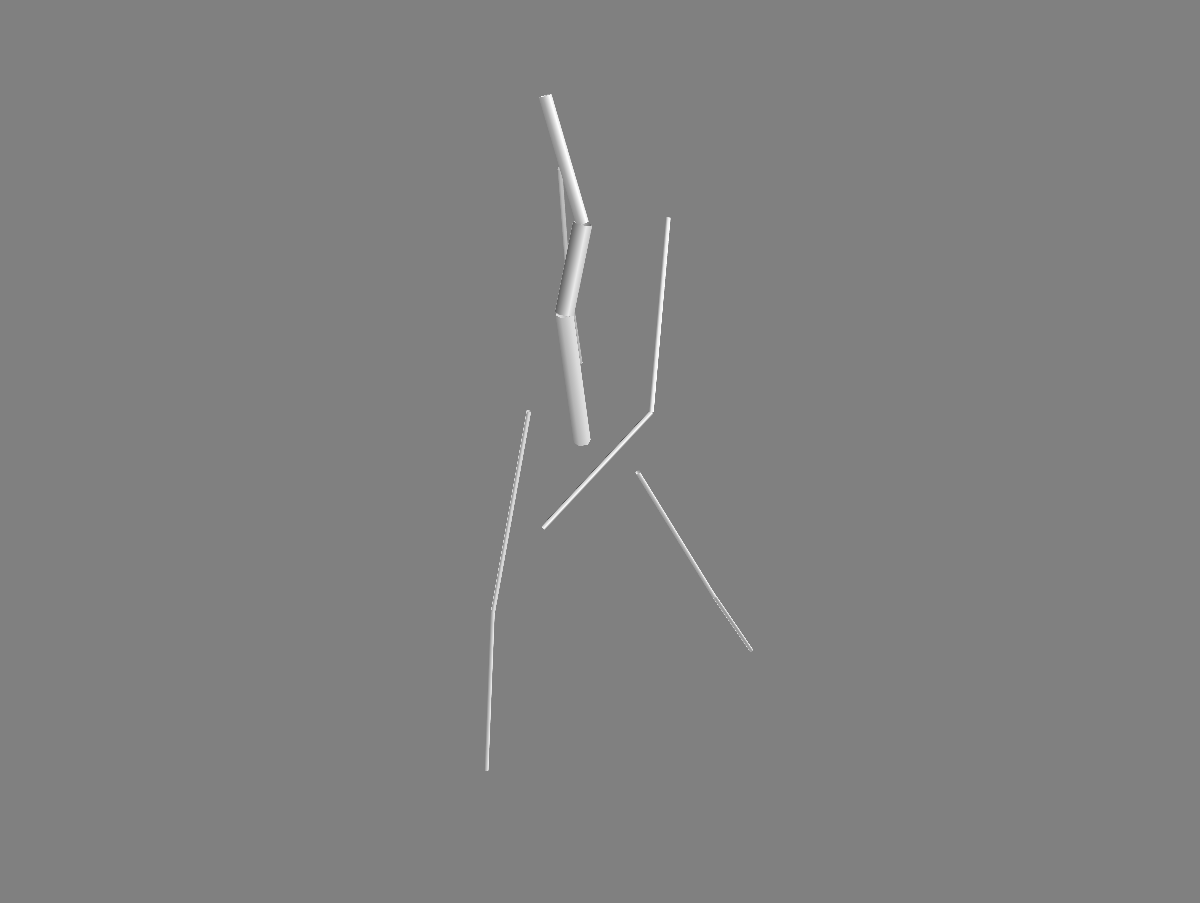

In [4]:
John._show3()
mau.inotshow('John',doc=True)

## Description of a body file

An example of a body file is given below. It is a file in `ini` format with 4 sections. 

+ [nodes] 
 
   This section associates a node number to a c3d fils conventional  node number 
   
    NodeId = C3DNODE
    
+ [cylinder]

   This section associates a cylinder Id to a dictionnary wich contains cylinder tail head and radius information 
   
      CylId = {'t',NodeId1,'h',NodeId2,'r',float (m),'name',}
      
+ [device]

   This section associates a device name to a dictionnary wich contains cylinder device related information
   
       DevId = {'typ' : {static|mobile} 
                 'cyl': CylId 
                 'l'  : length coordinate in ccs,
                 'h'  : height coordinate in ccs, 
                 'a'  : angle coordinate in ccs, 
                 'file' : antenna file , 
                 'T' : Rotation matrix }
   

## Example of a Body file 

    [nodes]
    0 = [STRN,T10]
    1 = [CLAV,C7]
    2 = [RFHD,LFHD,LBHD,RBHD]
    3 = RSHO
    4 = LSHO
    5 = [RRAD,RHUM]
    6 = [LRAD,LHUM]
    7 = [RWRA,RWRB]
    8 = [LWRA,LWRB]
    9 = [RFWT,RBWT]
    10 = [LFWT,LBWT]
    11 = [RKNE,RKNI]
    12 = [LKNE,LKNI]
    13 = RANI
    14 = LANI
    15 = [RFWT, LFWT,LBWT,RBWT]
    [cylinder]
    ; sternum (STRN) - clavicle (CLAV)
    trunku = {'t':0,'h':1,'r':0.18,'i':0}
    ; bottom  (BOTT) sternum (STRN)  
    trunkb = {'t':15,'h':0,'r':0.17,'i':10}
    ; clavicle (CLAV)  - head (RFHD)
    headu = {'t':1,'h':2,'r':0.12,'i':1}
    ; right elbow (RELB)  right shoulder (RSHO)
    armr = {'t':5,'h':3,'r':0.05,'i':2}
    ; left elbow (LELB)  left shoulder (LSHO)
    arml  = {'t':6,'h':4,'r':0.05,'i':3}
    ; right wrist (RWRB) right elbow (RELB)  
    forearmr = {'t':7,'h':5,'r':0.05,'i':4}
    ; left wrist (LWRB)  left elbow (LELB)  
    forearml = {'t':8,'h':6,'r':0.05,'i':5}
    ; right knee (RKNE) right hip (RFWT)  
    thighr = {'t':11,'h':9,'r':0.05,'i':6}
    ; left knee (LKNE)  left hip (LFWT)  
    thighl = {'t':12,'h':10,'r':0.05,'i':7}
    ; right ankle (RANK) right knee (RKNE)  
    calfr = {'t':13,'h':11,'r':0.05,'i':8}
    ; left ankle (LANK) left knee (LKNE)  
    calfl = {'t':14,'h':12,'r':0.05,'i':9}
    [wearable]
    file = real_suit1.ini
    [mocap]
    file = serie_017_noDEC_Real.c3d
    ; unit of c3d file
    unit = mm
    ; number of frame to consider. if -1 : all frames
    nframes = -1


In [5]:
Bernard = Body(_filebody='Bernard.ini',_filemocap='serie_017.c3d')

**** Processor coding : DEC-VAX


## Loading a Motion Capture File

A `.c3d` motion capture file is loaded with the method **`loadC3D`** with as arguments the motion capture file and the number of frames to load.  

The motion is represented as a sequence of frames stored in the **`d`** variable member.

It is possible to get the information from the C3D header by using the verbose option of the `read_c3d` function

In [6]:
# Video Frame Rate 
Vrate = 120
# Inter Frame
Tframe = 1./120
# select a number of frame 
nframes = 300
# Time duration of the whole selected frame sequence
Tfseq = Tframe*nframes
#
# load a .c3dmotion capture file
# this update the g.pos 
#
#bc.loadC3D(filename='07_01.c3d',nframes=nframes,centered=True)

The duration of the capture is 

In [7]:
print "Duration of the motion capture sequence", Tfseq," seconds"

Duration of the motion capture sequence 2.5  seconds


`d` is a MDA of shape `(3,npoint,nframe)`. It contains all the possible configurations of the body. In general it is supposed to be a cyclic motion as an integer number of walking steps. This allows to instantiate the body configuration anywhere else in space in a given trajectory. 

A specific space-time configuration of the body is called a **`topos`**.

In [8]:
np.shape(Bernard.d)

(3, 16, 11213)

## Defining a trajectory

A Trajectory is a class which : 

+ derives from a pandas `DataFrame` 
+ is a container for time,position,velocity and acceleration. 
 

In [9]:
traj = Trajectory()

To define a default trajectory :

In [10]:
t = traj.generate()

In [11]:
print traj.columns

Index([u'x', u'y', u'z', u'vx', u'vy', u'vz', u'ax', u'ay', u'az', u's'], dtype='object')


In [12]:
traj.head()

,x,y,z,vx,vy,vz,ax,ay,az,s
1970-01-01 00:00:00,0.000000,0.000000,-0.779591,0.299813,1,4.267809,-0.005505,0,-17.755143,0.000000
1970-01-01 00:00:00.204082,0.061186,0.204082,0.091390,0.298689,1,0.644311,-0.010989,0,-1.500064,0.213056
1970-01-01 00:00:00.408163,0.122143,0.408163,0.222882,0.296446,1,0.338175,-0.016433,0,12.000857,0.426047
1970-01-01 00:00:00.612245,0.182642,0.612245,0.291897,0.293093,1,2.787330,-0.021814,0,-4.164700,0.638907
1970-01-01 00:00:00.816327,0.242457,0.816327,0.860740,0.288641,1,1.937391,-0.027114,0,-20.857234,0.851574


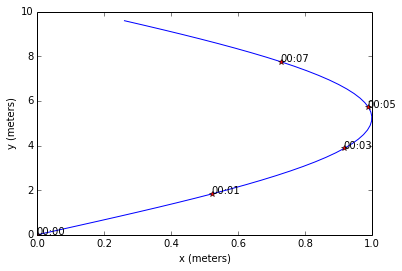

In [13]:
f,a = traj.plot()

### settopos () method

Once the trajectory has been defined it is possible to send the body at the position corresponding to any time 
of the trajectory with the **`settopos`** method. 

settopos takes as argument 

+ A trajectory 
+ A time index

In [14]:
traj.__repr__()

'Trajectory of agent MyNameIsNoBody with ID 1\n--------------------------------------------\nt (s) : 0.00 : 0.20 : 9.59\ndtot (m) : 9.79\nVmoy (m/s) : 1.02\n                                   x         y         z        vx  vy  \\\n1970-01-01 00:00:00         0.000000  0.000000 -0.779591  0.299813   1   \n1970-01-01 00:00:00.204082  0.061186  0.204082  0.091390  0.298689   1   \n\n                                  vz        ax  ay         az         s  \n1970-01-01 00:00:00         4.267809 -0.005505   0 -17.755143  0.000000  \n1970-01-01 00:00:00.204082  0.644311 -0.010989   0  -1.500064  0.213056  \n'

In [15]:
John.settopos(traj,t=5)

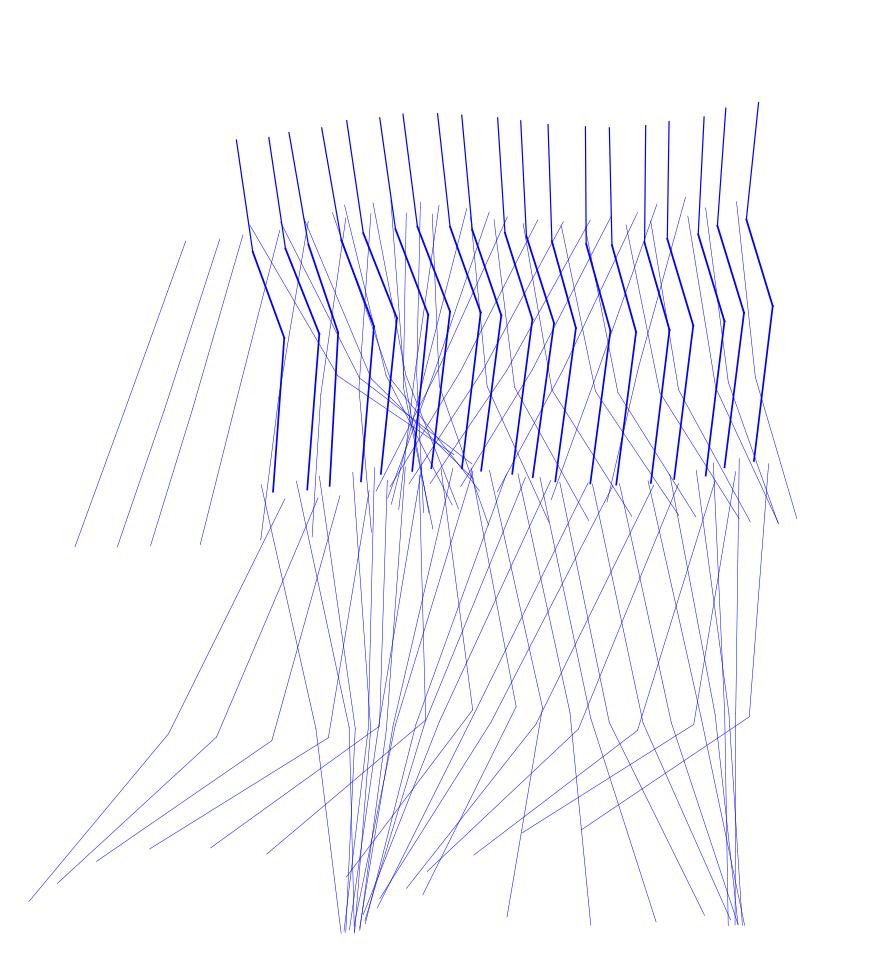

In [16]:
plt.figure(figsize=(15,20))
for t in np.arange(traj.tmin+0.4,traj.tmax,0.5):
    John.settopos(traj,t=t)
    f,a=John.show(color='b',plane='yz',topos=True)
    axis('off')

In [17]:
John

My name is : John

I have a Galaxy Gear device with id #1 on the left forearm
I have a cardio device with id #0 on the upper part of trunk

@ t=0.710582010582 (frameID=85),
My centroid position is [-7.87435024  5.23416696]

filewear : suit2.ini
filename : 07_01.c3d
nframes : 316
Centered : True
Mocap Speed : 13.605 m/s 


In [18]:
Francois = Body(_filebody='Francois.ini')
Francois

**** Processor coding : Intel-PC


My name is : Francois

I have a Galaxy Gear device with id #1 on the left forearm
I have a cardio device with id #0 on the upper part of trunk

I am nowhere yet

filewear : suit2.ini
filename : 07_01.c3d
nframes : 300
Centered : True
Mocap Speed : 13.656 m/s 


In [19]:
Francois.settopos(traj,t=6)
Francois

My name is : Francois

I have a Galaxy Gear device with id #1 on the left forearm
I have a cardio device with id #0 on the upper part of trunk

@ t=0.443143812709 (frameID=53),
My centroid position is [-11.4689352    4.97981336]

filewear : suit2.ini
filename : 07_01.c3d
nframes : 300
Centered : True
Mocap Speed : 13.656 m/s 


+ 3  : dimension of space
+ 16 : number of nodes
+ 300 : number of frames 

The figure below shows the projection in a vertival plane of the body nodes. 

## Centering the motion

In [20]:
John.centered

True

In order to translate the motion in any point in space-time, a distinction is made between the real motion or topos and the centered motion capture which acts as a virtual motion. 

Let $\mathbf{p}^k$ denotes the center of gravity of the body in the (O,x,y) plane

In [21]:
John.center()

In [22]:
a = np.hstack((John.vg,John.vg[:,-1][:,np.newaxis]))

$\mathbf{v}_g$ is the velocity vector of the gravity center of the body.

In [23]:
print np.shape(John.pg)
print np.shape(John.vg)

(3, 316)
(3, 316)


In [24]:
print John.vg[:,145]
print John.vg[:,298]

[ 0.11498696 -0.00263353  0.        ]
[ 0.10812351  0.00072441  0.        ]


At that point the body structure is centered. 



The frame is centered in the xy plane by substracting from the configuration of points the projection of the body in the xy plane. 

In [25]:
np.shape(John.d)

(3, 16, 316)

In [26]:
John.npoints

16

Each frame is centered above the origin. For example for a walk motion the effect of the centering is just like if the body was still walking but not moving forward exactly in the same manner as a walk on a conveyor belt.

In [27]:
pgc = np.sum(John.d[:,:,0],axis=1)/16
pg0 = John.pg[:,0]
print "True center of gravity", pg0
print "Center of gravity of the centered frame",pgc

True center of gravity [-17.42515686   4.93730766   0.        ]
Center of gravity of the centered frame [  4.44089210e-16  -1.05471187e-15   8.94887349e+00]


In [28]:
np.shape(John.pg)

(3, 316)

The current file contains 300 frames

In [29]:
tframe = np.arange(John.nframes)

In [30]:
np.shape(John.pg[0:-1,:])

(2, 316)

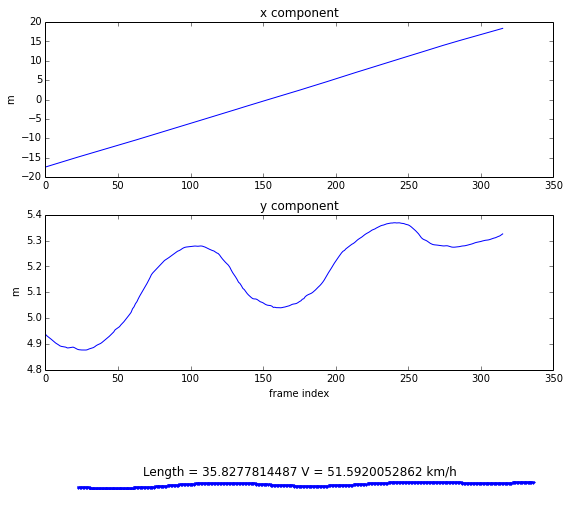

In [31]:
xg = John.pg[0,:]
yg = John.pg[1,:]
zg = John.pg[2,:]
figure(figsize=(8,8))
subplot(311)
plot(tframe,xg)
title('x component')
ylabel('m')
subplot(312)
xlabel('frame index')
title('y component')
ylabel('m')
plot(tframe,yg)
subplot(313)
xlabel('frame index')
title('Motion capture centroid trajectory')
ylabel('m')
plot(xg,yg,'.b')

d = John.pg[0:-1,1:]-John.pg[0:-1,0:-1]
smocap = np.cumsum(np.sqrt(np.sum(d*d,axis=0)))

Vmocap = smocap[-1]/Tfseq
title('Length = '+str(smocap[-1])+' V = '+str(Vmocap*3.6)+' km/h')
axis('scaled')
axis('off')
plt.tight_layout()

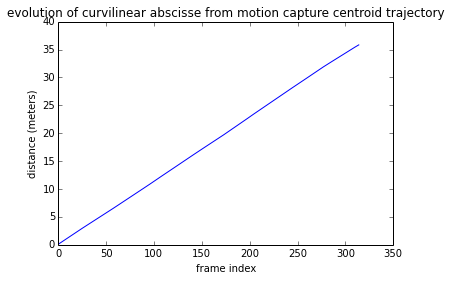

In [32]:
plot(smocap)
title('evolution of curvilinear abscisse from motion capture centroid trajectory') 
xlabel('frame index')
ylabel('distance (meters)')

## Defining a large scale trajectory 

A large scale trajectory is defined in the $(O,x,y)$ plane.

`traj` is a data structure (Npt,2)

In [33]:
v = Vmocap
print v*3.6,"Kmph"

51.5920052862 Kmph


In [34]:
# time in seconds
time = np.arange(0,10,0.01)
x = v*time
y = np.zeros(len(time))
z = np.zeros(len(time))
traj = Trajectory()
traj.generate()
traj.tmax

9.591837

,x,y,z,vx,vy,vz,ax,ay,az,s
1970-01-01 00:00:00,0.000000,0.000000,-0.093771,0.299813,1,0.765402,-0.005505,0,-10.267125,0.000000
1970-01-01 00:00:00.204082,0.061186,0.204082,0.062433,0.298689,1,-1.329930,-0.010989,0,60.089719,0.213056
1970-01-01 00:00:00.408163,0.122143,0.408163,-0.208981,0.296446,1,10.933278,-0.016433,0,-97.569371,0.426047
1970-01-01 00:00:00.612245,0.182642,0.612245,2.022300,0.293093,1,-8.978838,-0.021814,0,29.555173,0.638907
1970-01-01 00:00:00.816327,0.242457,0.816327,0.189884,0.288641,1,-2.947170,-0.027114,0,11.499492,0.851574


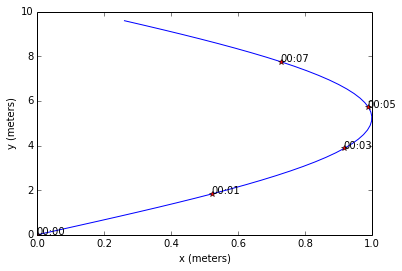

In [35]:
fig ,ax = traj.plot()
traj.head()

## Trajectory

## `posvel()`




The `posvel()` method (position and velocity) takes as arguments the following parameters 

+ `traj` a plane trajectory object.
+ $t_k$ time for evaluation of topos 
+ $T_{fs}$ duration of the periodic motion frame sequence 

and returns 

+ the frame index $k_f = \lfloor \frac{t_k \pmod{T_{fs}}}{t_f} \rfloor$
+ the trajectory index $k_t = \lfloor t_k \rfloor$
+ velocity unitary vector along motion capture frame $\hat{\mathbf{v}}_s = \frac{\mathbf{p}^g[k_f]-\mathbf{p}^g[k_f-1]}{|\mathbf{p}^g[k_f]-\mathbf{p}^g[k_f-1]|}$
+ $\hat{\mathbf{w}}_s = \mathbf{\hat{z}} \times  \hat{\mathbf{v}}_s $
+  velocity unitary vector along trajectory $\hat{\mathbf{v}}_t = \frac{\mathbf{p}^t[k_t]-\mathbf{p}^g[k_t-1]}{|\mathbf{p}^g[k_t]-\mathbf{p}^t[k_t-1]|}$
+ $\hat{\mathbf{w}}_t = \mathbf{\hat{z}} \times  \hat{\mathbf{v}}_t $

$t_f = \frac{T_{fs}}{Nf}$ is the interframe time or frame sampling period, it is equal to the whole duration of the motion sequence $T_{fs}$ divided by the number of frames





`settopos` is a method which takes as argument : 

+ `traj` a plane trajectory (Npt,2)
+ $t_k$ time for evaluation of topos 

In further version of the class, this function will be modified to avoid passing the whole trajectory. 

In [36]:
John.settopos(traj=traj,t=3)

There is now a new data structure in the Body objet. This data structure is called a `topos`.

In [37]:
print np.shape(John.topos)

(3, 16)


In [38]:
John.topos

array([[  0.74198686,   0.76931593,   1.80846633,   2.26719915,
         -0.91675363,   3.25586636,  -1.86053098,   3.82194596,
         -2.06245933,   2.15021298,  -0.55180885,   2.02586803,
         -0.94510502,   1.36586716,  -0.57366714,   0.79920206],
       [  3.75720113,   3.13644711,   2.8414143 ,   2.20063108,
          2.6901425 ,   1.78826275,   3.20212316,   1.7696506 ,
          4.042258  ,   3.29688912,   3.60268634,   2.76571804,
          3.90430304,   2.24259271,   1.0241781 ,   3.44978773],
       [ 12.24457275,  13.88075684,  16.00988037,  14.0978418 ,
         14.3736377 ,  10.74208496,  11.07206543,   7.98268372,
          8.47460388,   9.31935974,   9.1988916 ,   4.30262299,
          4.54000305,   0.44698982,   1.7794635 ,   9.25912567]])

In [39]:
John.show3()

(<matplotlib.figure.Figure at 0x7f2179854c90>,
 <matplotlib.axes.Axes3DSubplot at 0x7f217987dd90>)

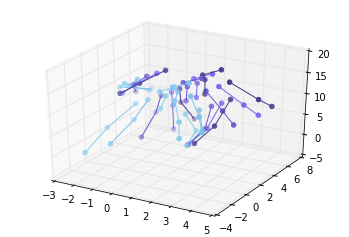

In [40]:
John.settopos(traj=traj,t=1)
fig,ax=John.plot3d(topos=True,col='#87CEEB')
John.settopos(traj=traj,t=2)
John.plot3d(topos=True,fig=fig,ax=ax,col='#7EC0EE')
John.settopos(traj=traj,t=3)
John.plot3d(topos=True,fig=fig,ax=ax,col='#6A5ACD')
John.settopos(traj=traj,t=4)
John.plot3d(topos=True,fig=fig,ax=ax,col='#7A67EE')
John.settopos(traj=traj,t=5)
John.plot3d(topos=True,fig=fig,ax=ax,col='#473C8B')

## Definition of Several Coordinates systems

Each cylinder of the `Body` model bears one specific coordinate system. 

One or several cylinder coordinate systems can be chosen to define the Body Local Coordinates System (BLCS) which is required for motion capture (BLCS) applications. 

In general, the origin will be chosen on a position which is the most time invariant as on the chest or the back. 


Those frames of references are all defined in the Global Coordinate System (GCS) of the scene.

### Construction of the Cylinder Coordinate System (CCS)

The method `setccs()` is used to associate a Cylinder Coordinate System (CCS) to each cylinder of the bodyCylinder model. Notice that those cylinders coordinates systems are not known by the localization application. The localization application will define the BLCS from the position of radiating devices placed on the body surface. 

Each basis is constructed with the function from `geomutil.onbfromaxe()` : orthonormal bases from axes. This function takes 2 sets of $n$ points $\mathbf{p}_{A,n}$ and $\mathbf{p}_{B,n}$ as input and provides an orthonormal basis as output. 

3 unitary vectors are constructed :


$$\hat{\mathbf{w}}_n = \frac{\mathbf{p}_B-\mathbf{p}_A}{| \mathbf{p}_B-\mathbf{p}_A |} $$

$$\hat{\mathbf{u}}_n = \frac{\hat{\mathbf{v}}_g - (\hat{\mathbf{v}}_g.{\hat{\mathbf{w}}_n}) \mathbf{\hat{w}}_n}{|\hat{\mathbf{v}_g} - (\hat{\mathbf{v}_g}.{\hat{\mathbf{w}}_n}) \mathbf{\hat{w}}_n|} $$

$$\hat{\mathbf{v}}_n = \mathbf{\hat{w}}_n \times \mathbf{\hat{u}}_n  $$

Where $\hat{\mathbf{v}}_g$ is the unit velocity vector along actual trajectory.  

The outpout of `geomutil.onbframe` is an MDA  $(3\times n \times 3)$ of $n$ unitary matrices aggregated along axis 1 $$\mathbf{T}_n=[\hat{\mathbf{u}}_n, \hat{\mathbf{v}}_n, \hat{\mathbf{w}}_n]$$


To create the CCS : 

In [41]:
John.setccs()

In [42]:
import scipy.linalg as la 
print "ccs dimensions : ",np.shape(John.ccs)
print John.ccs[0,:,:]
print "Check determinant : ", la.det(John.ccs[0,:,:])

ccs dimensions :  (11, 3, 3)
[[ 0.94678656  0.05306765 -0.31745715]
 [-0.06834689  0.99696857 -0.03718026]
 [ 0.31452173  0.05689898  0.94754345]]
Check determinant :  1.0


Create a Wireframe body representation from the body graph model

Representation of frames associated with the cylinder

In [43]:
John._show3()

On the figure below the wireframe model is shown associated with the 11 CCS (Cylinder coordinates systems) 

In [44]:
Image('CCS.png')

## Placing a dcs (Device Coordinate System ) on the cylinder

A DCS is refered by 4 numbers $(Id,l,h,\alpha)$

+ Id : Cylinder Id
+ l : length along cylinder
+ h : height above cylinder generatrix
+ alpha : angle from front direction (degrees)

In [45]:
Id = 4 # 4 Left Arm
l  = 0.1 # Longitudinal coordinates
h  = 0.03 # height 
alpha = 45 # angle degrees

In [46]:
John.dcyl

{'arml': 3,
 'armr': 2,
 'calfl': 9,
 'calfr': 8,
 'forearml': 5,
 'forearmr': 4,
 'headu': 1,
 'thighl': 7,
 'thighr': 6,
 'trunkb': 10,
 'trunku': 0}

Rotate Matrix around z

In [47]:
John.settopos(traj=traj,t=6,cs=True)

In [48]:
John.dcyl

{'arml': 3,
 'armr': 2,
 'calfl': 9,
 'calfr': 8,
 'forearml': 5,
 'forearmr': 4,
 'headu': 1,
 'thighl': 7,
 'thighr': 6,
 'trunkb': 10,
 'trunku': 0}

In [49]:
John.show3(topos=True,dcs=True)

In [50]:
John.show3(topos=True,pattern=True)

In [51]:
#Image('acs.png')

In [52]:
#Bernard = Body(_filebody='Bernard.ini',_filemocap='serie_017.c3d')
#fig1 = plt.figure(figsize=(20,15))
#fstart=100
#fend = 11000
#for f in range(fstart,fend,1000):
#    Bernard.show(color='b',plane='xy',widthfactor=50,offset=f/10,frameId=f)


In [53]:
#fig1 = plt.figure(figsize=(20,5))    
#for f in range(fstart,fend,500):
#    Bernard.show(color='b',plane='yz',widthfactor=50,offset=f/10,frameId=f) 

In [54]:
#Bernard.anim(Bernard)

In [55]:
from IPython.core.display import HTML

def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()